# Implementing controlled operations |i><i|\otimes U_i using 'Control' from meta

Take any integer in its binary form, say 12 = 1100 and then do the right combination of X's to map 1100 ---> 1111, the target string being always the all 1s string. Then use Control. 


Strange issue : some parts of the lcu junk state are picking up phase factors of -1
For example, with CPhase, the post-lcu state should be
        00 ( 0+ + 1- )
       +01 ( 1+ + 0- )
       +10 ( 0+ - 1- )
       +11 ( 1+ - 0- )
but our code produces
        00 ( 0+ + 1- )
       -01 ( 1+ + 0- )
       -10 ( 0+ - 1- )
       +11 ( 1+ - 0- )
       
Is this an artifact of the use of X's in the control segments? Note that the negative sign seems to show up whenever there's an odd parity string.

In [9]:
if __name__ == "__main__":
    eng = MainEngine()
#     test_controlled_phase_12(eng,0,10)
    
    prob_theory=[]
    prob_prac=[]
    for j, amp in enumerate(np.linspace(-0.5,0.5,21,endpoint=True)):
        print("\n*** For cluster amplitude = {} ***".format(float(amp)))
        fpoaa_min = 0
        fpoaa_max = 7
        probs = []
        for i in range(fpoaa_min, fpoaa_max):
            probs.append(test_CCS(eng, amp, 0, i))
    
        pt, pp = zip(*probs)
        prob_theory.append(pt)
        prob_prac.append(pp)
#         print("probability discrepancy as a function of #rounds of fpoaa:\n")
#         delta_prob = np.subtract(prob_theory,prob_prac)
#         print(delta_prob)
        print("practically achieved success probability as a function of #rounds of fpoaa:\n")
#        print(range(fpoaa_min, fpoaa_max))
        print(prob_prac[j])
#        print(prob_theory)



*** For cluster amplitude = -0.5 ***
practically achieved success probability as a function of #rounds of fpoaa:

(0.4722222222222595, 0.7747985253773376, 0.9624460482118558, 0.9997883471523866, 0.9999999999620743, 1.0000000000000038, 1.0000000000000082)

*** For cluster amplitude = -0.45 ***
practically achieved success probability as a function of #rounds of fpoaa:

(0.49970273483955135, 0.8060222168528808, 0.975780463761239, 0.999943218068214, 0.9999999999992675, 1.0000000000000089, 1.0000000000000213)

*** For cluster amplitude = -0.4 ***
practically achieved success probability as a function of #rounds of fpoaa:

(0.5306122448982792, 0.8379331741030078, 0.9857462229004619, 0.9999884241678666, 0.9999999999999906, 0.9999999999999927, 0.999999999999982)

*** For cluster amplitude = -0.35 ***
practically achieved success probability as a function of #rounds of fpoaa:

(0.5655006858711287, 0.8698969024536416, 0.9925593006581108, 0.9999983531738612, 1.0000000000000089, 1.00000000000002

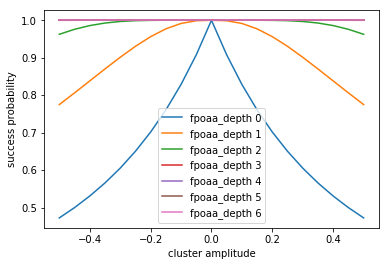

In [16]:
prob_as_fn_of_amps = list(zip(*prob_prac))       # transposing the list of lists
for i in range(len(prob_as_fn_of_amps)):
    plt.plot(np.linspace(-0.5,0.5,21,endpoint=True), prob_as_fn_of_amps[i], label = 'fpoaa_depth %s'%i)
plt.xlabel("cluster amplitude")
plt.ylabel("success probability")
plt.legend(loc='best')
plt.show()

# plt.plot(range(4,test_fpoaa),prob_theory,'r-',range(4,test_fpoaa),prob_prac,'bo')
# plt.show()


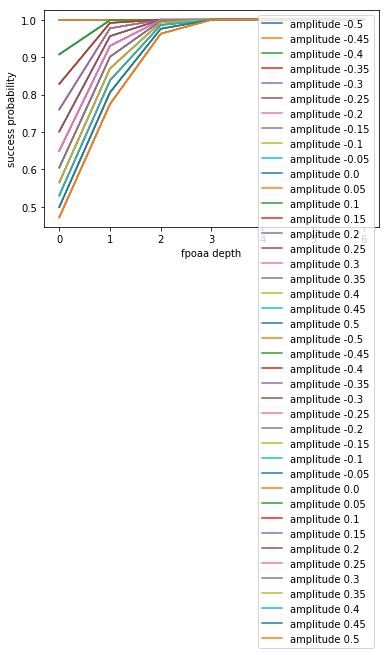

In [19]:
for i, amp in enumerate(np.linspace(-0.5,0.5,21,endpoint=True)):
    plt.plot(range(fpoaa_min,fpoaa_max), prob_prac[i], label = 'amplitude %s'%amp)
plt.xlabel("fpoaa depth")
plt.ylabel("success probability")
plt.legend(loc='best')
plt.show()

In [ ]:

amps_0 = np.loadtxt("CCS_amp_0.0_data.txt", dtype=complex)
target = np.ones(len(amps_0),dtype=complex)
diff_state = np.subtract(amps_0,target)
err_0 = np.absolute(diff_state)
print(err_0)


The following is VQE code using the scipy.optimize.minimize in the classical optimisation loop, and the vCC ansatz that uses the above functions for state preparation.

In [1]:
import numpy as np                          # for rank_1_projector and other custom matrices
import math
import matplotlib.pyplot as plt
from collections import Counter

from projectq import MainEngine
from projectq.ops import H, Ry, Rx, X, Y, Z, R, Ph, All, Measure, ControlledGate
                                            # Ph for global phase
                                            # R is for phase gates
from projectq.ops._basics import SelfInverseGate
                                            # because they don't have a named identity
        
from projectq.meta import Dagger, Compute, Uncompute, Control

from projectq.ops import QubitOperator

from openfermion.hamiltonians import MolecularData

from openfermion.transforms import get_fermion_operator, jordan_wigner

In [ ]:
def cc_quantum_coprocessor(theta, *ccargs):
    """
    Arguments:
        theta (float): variational parameters for ansatz wavefunction
        hamiltonian (QubitOperator): Hamiltonian of the system
    Returns:
        energy of the trial wavefunction for parameter theta
    """
    # unpack arguments
    eng = ccargs[0]
    hamiltonian = ccargs[1]
    n_orbitals = ccargs[2]
    n_electrons = ccargs[3]
        
    n_unocc = n_orbitals - n_electrons
    
    # operator for making Hartree-Fock initial state |00...01...1>
    unocc = eng.allocate_qureg(n_unocc)
    occ = eng.allocate_qureg(n_electrons)
    cc_trial = occ+unocc
    hf_str = tuple((index, 'X') for
                              index in range(n_unocc))
    hf_init_op = QubitOperator(hf_str, 1.0)
    
    # Allocate LCU control reg - depends on excitation order trunc
    ctrl_dim = 2*trunc + 1
    ctrl = eng.allocate_qureg[ctrl_dim]
    # the lcu algo takes the state [ctrl|occ|unocc]
    cc_lcu = ctrl+cc_trial
    
    # tare to all zeros state (when picking up from failed LCU)
    for i in range(0,n_orbitals+ctrl+dim):
        Measure | cc_lcu[i]
        if(bool(cc_lcu[i])):
            X | cc_lcu[i]
    # set unocc orbitals to 1 (0 = occ)
    hf_init_op | unocc
            
    # Build CCSD operator for vCC ansatz wavefunction
    # unpack CC amplitudes 
    n_sings = n_orbitals*n_orbitals
    n_doubs = n_sings*n_sings
    single_amps = theta[:n_sings].reshape(n_orbitals,n_orbitals)
    double_amps = theta[n_sings:].reshape(n_orbitals,n_orbitals,n_orbitals,n_orbitals)
    # save the max of all amps to determine fpoaa depth
    t_max = np.amax([abs(x) for x in theta])
    # and convert amps to lists of nonzeros, with indices, coeft, and number of time slices
    time_slicing_threshold = 0.05
    single_amps, double_amps = generate_term_list(
            single_amps, double_amps, time_slicing_threshold)
    # save number of nonzeros for later use
    n_terms = len(single_amps) + len(double_amps)
    
    # set success probability level for LCU steps, p_succ = 1-eps
    # eps in our method depends on the max number of 'time' slices 
    # and the total number of terms, as eps = 1/CrM
    # this give overall succ probability of the method as ~ (1/e)^1/C, in theory
    # C=5 goves p > 0.81
    C = 5
    r = np.amax([term[2] for term in single_amps+double_amps])
    eps = 1.0/(C*r*n_terms)
    
    # fpoaa depth k => 3^k = (log p_fail)/(log 2t_max)
    fpoaa_queries = math.log(eps, 10)/math.log(2*t_max, 10)
    if (fpoaa_queries>=3):
        fpoaa_depth = math.log(fpoaa_queries,3)
    else:
        fpoaa_depth = 0    
    
    # Apply lcu term by term, first all singles, then all doubles
    # Loop over this until success
    # start from top every time LCU+post fails
    for [i,j], t, r in single_amps:
        i,j = sorted(i,j)
        op_str = str(j)+'^'+' '+str(i)
        fer_op = FermionOperator(op_str, 1.0)
        qub_op = QubitOperator('', 1.0) + jordan_wigner(fer_op)
        for term in qub_op.terms:
            coeft = qub_op.terms[term]/abs(qubit_op.terms[term])
            lcu += [QubitOperator(term, coeft)]
        coefts = [0.25*t for x in range(4)]
        coefts = np.concatenate(([1.0], coefts))
        
    for [i,j,k,l], t, r in double_amps:
        i,j,k,l = sorted([i,j,k,l])
        op_str = str(k)+'^'+' '+str(l)+'^'+' '+str(j)+' '+str(i)
        fer_op = FermionOperator(op_str, 1.0)
        qub_op = QubitOperator('', 1.0) + jordan_wigner(fer_op)
        for term in qub_op.terms:
            coeft = qub_op.terms[term]/abs(qubit_op.terms[term])
            lcu += [QubitOperator(term, coeft)]
        coefts = [0.0625*t for x in range(16)]
        coefts = np.concatenate(([1.0], coefts))
        # Apply the LCU unitary and FPOAA
        
        # Measure ancillae and postselect on getting 0
        
    # flush all gates
    eng.flush()
    # Calculate the energy.
    # ProjectQ simulator can directly return expectation values
    # In reality need to implement Hamiltonian averaging term-wise
    energy = eng.backend.get_expectation_value(hamiltonian, wavefunction)
    # Measure all to satisfy projectq simulator
    All(Measure) | wavefunction
    return energy

In [2]:
# from openfermion/utils/_unitary_cc.py
def generate_term_list(single_amplitudes, double_amplitudes, threshold=0.05):
    """Re-format single_amplitudes and double_amplitudes from ndarrays to lists.
    Args:
        single_amplitudes(ndarray): [NxN] array storing single excitation
            amplitudes corresponding to t[i,j] * (a_i^\dagger a_j - H.C.)
        double_amplitudes(ndarray): [NxNxNxN] array storing double
            excitation amplitudes corresponding to
            t[i,j,k,l] * (a_i^\dagger a_j a_k^\dagger a_l - H.C.)
    Returns:
        single_amplitudes_list(list): list of lists with each sublist storing
            a list of indices followed by single excitation amplitudes,
            and number of time slices
            i.e. [[[i,j],t_ij, r_ij], ...]
        double_amplitudes_list(list): list of lists with each sublist storing
            a list of indices followed by double excitation amplitudes
            and number of time slices
            i.e. [[[i,j,k,l],t_ijkl, r_ijkl], ...]
    """
    single_amplitudes_list, double_amplitudes_list = [], []

    for i, j in zip(*single_amplitudes.nonzero()):
        r = math.ceil(single_amplitudes[i, j]/threshold)
        if r <= 1:
            r=1           
        single_amplitudes_list.append([[i, j], single_amplitudes[i, j], r])

    for i, j, k, l in zip(*double_amplitudes.nonzero()):
        r = math.ceil(double_amplitudes[i, j, k, l]/threshold)
        if r <= 1:
            r=1
        double_amplitudes_list.append([[i, j, k, l],
                                      double_amplitudes[i, j, k, l], r])
    return single_amplitudes_list, double_amplitudes_list


def vqe_classical_processor():
    
    """
    Read MolecularData from HDF5 output of OpenFermion-Psi4
    Populate bond_lengths, extract hamiltonian
    """
    
    eng = MainEngine()
    
    bond_lengths = []
    bond_distances = []
    
    folder = '/store/DAMTP/ss2310/anaconda3/lib/python3.6/site-packages/openfermion/data/'
    molecular_details = 'N2_cc-pVDZ_singlet_'
    file_i = folder + molecular_details + str(bond_distances[i])
    
    # Load data from HDF5 computed using Openfermion-Psi4
    molecule = MolecularData(filename=file_i)
    n_orbs = molecule.n_qubits
    n_elec = molecule.n_electrons
    
    # Extract initial guesses for CCSD single and double amplitudes
    # stored as numpy arrays
    # 1) MolecularData not storing MP2 amplitudes.. 2) faster convergence 
    ccsd_single_init = molecule.ccsd_single_amps
    ccsd_double_init = molecule.ccsd_double_amps
    theta = np.hstack([ccsd_single_init.flatten(), ccsd_double_init.flatten()])

    # Convert hamiltonian to QubitOperator using JW
    molecule_qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
        
    # Classical optimisation loop using scipy.optimize.minimize
    # for variational parameters theta (= CC amplitudes here)
    # Can pass different scipy optimizer options: Brent, Golden, Bounded
    minimum = minimize(cc_quantum_coprocessor, theta, args=(eng, hamiltonian, n_orbs, n_elec), method='Nelder-Mead')
    lowest_energies.append(minimum.fun)
    
    # Note that in grove, they use scipy.optimize.minimize: has Nelder-Mead etc
